In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

from pytorch_mlp import MLP

In [2]:
def generate_data():
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train)
    y_test_onehot = encoder.transform(y_test)
    return X_train, X_test, y_train_onehot, y_test_onehot

X_train, X_test, y_train, y_test = generate_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 2) (200, 2) (800, 2) (200, 2)


In [3]:
class MoonDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def get_dataloaders(batch_size: int = 32, shuffle: bool = True, num_workers: int = 0,
                    pin_memory: bool = False):
    X_train, X_test, y_train, y_test = generate_data()
    train_ds = MoonDataset(X_train, y_train)
    test_ds = MoonDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle,
                              num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)
    return train_loader, test_loader

In [5]:
train_loader, test_loader = get_dataloaders(batch_size=64)
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([64, 2]) torch.Size([64, 2])


In [17]:
def accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    # targets: long class index (N,) or one-hot (N,C)
    if targets.dtype != torch.long or targets.ndim != 1:
        targets = targets.argmax(dim=1)
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()
    
def train(model, learning_rate, max_epochs, eval_freq):
    train_loader, test_loader = get_dataloaders(batch_size=64)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_losses, test_losses = [], []

    for epoch in range(1, max_epochs + 1):
        model.train()
        running_loss, running_acc, n_batches = 0.0, 0.0, 0
        for xb, yb in train_loader:
            y_idx = yb.argmax(dim=1) if (yb.dtype != torch.long or yb.ndim != 1) else yb

            logits = model(xb)
            loss = criterion(logits, y_idx)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += accuracy(logits, yb)
            n_batches += 1

        avg_train_loss = running_loss / max(n_batches, 1)
        avg_train_acc = running_acc / max(n_batches, 1)
        train_losses.append(avg_train_loss)

        if (epoch % eval_freq == 0) or (epoch == max_epochs):
            model.eval()
            test_loss_sum, test_acc_sum, t_batches = 0.0, 0.0, 0
            with torch.no_grad():
                for xb, yb in test_loader:
                    y_idx = yb.argmax(dim=1) if (yb.dtype != torch.long or yb.ndim != 1) else yb
                    logits = model(xb)
                    loss = criterion(logits, y_idx)
                    test_loss_sum += loss.item()
                    test_acc_sum += accuracy(logits, yb)
                    t_batches += 1
            avg_test_loss = test_loss_sum / max(t_batches, 1)
            avg_test_acc = test_acc_sum / max(t_batches, 1)
            test_losses.append(avg_test_loss)

            print(f"Epoch {epoch:3d} | Train Loss {avg_train_loss:.4f} | "
                  f"Train Acc {avg_train_acc:.4f} | Test Loss {avg_test_loss:.4f} | "
                  f"Test Acc {avg_test_acc:.4f}")

    return train_losses, test_losses


In [18]:
model = MLP(2, [20], 2)
train_losses, test_losses = train(model, 0.01, 1000, 100)

Epoch 100 | Train Loss 0.2876 | Train Acc 0.8678 | Test Loss 0.3347 | Test Acc 0.8320
Epoch 200 | Train Loss 0.2472 | Train Acc 0.8822 | Test Loss 0.2715 | Test Acc 0.8438
Epoch 300 | Train Loss 0.2185 | Train Acc 0.8942 | Test Loss 0.2303 | Test Acc 0.9336
Epoch 400 | Train Loss 0.1984 | Train Acc 0.9111 | Test Loss 0.1986 | Test Acc 0.9414
Epoch 500 | Train Loss 0.1719 | Train Acc 0.9255 | Test Loss 0.1692 | Test Acc 0.9492
Epoch 600 | Train Loss 0.1483 | Train Acc 0.9339 | Test Loss 0.1418 | Test Acc 0.9531
Epoch 700 | Train Loss 0.1250 | Train Acc 0.9471 | Test Loss 0.1167 | Test Acc 0.9688
Epoch 800 | Train Loss 0.1077 | Train Acc 0.9627 | Test Loss 0.0955 | Test Acc 0.9805
Epoch 900 | Train Loss 0.0872 | Train Acc 0.9784 | Test Loss 0.0792 | Test Acc 0.9883
Epoch 1000 | Train Loss 0.0755 | Train Acc 0.9796 | Test Loss 0.0661 | Test Acc 0.9883


In [16]:
!python numpy_train_mlp.py --dnn_hidden_units 20 --learning_rate 0.01 --max_steps 1000 --eval_freq 100 --gd_mode 1 --batch_size 64

Epoch:   1 | Train Loss: 0.8861 | Train Acc: 36.66% | Test Loss: 0.6737 | Test Acc: 55.47%
Epoch: 101 | Train Loss: 0.2303 | Train Acc: 89.06% | Test Loss: 0.2471 | Test Acc: 92.58%
Epoch: 201 | Train Loss: 0.2010 | Train Acc: 91.35% | Test Loss: 0.2012 | Test Acc: 93.36%
Epoch: 301 | Train Loss: 0.1680 | Train Acc: 93.03% | Test Loss: 0.1625 | Test Acc: 94.92%
Epoch: 401 | Train Loss: 0.1423 | Train Acc: 94.35% | Test Loss: 0.1336 | Test Acc: 96.48%
Epoch: 501 | Train Loss: 0.1178 | Train Acc: 95.55% | Test Loss: 0.1063 | Test Acc: 97.66%
Epoch: 601 | Train Loss: 0.0969 | Train Acc: 97.00% | Test Loss: 0.0853 | Test Acc: 98.05%
Epoch: 701 | Train Loss: 0.0791 | Train Acc: 98.08% | Test Loss: 0.0696 | Test Acc: 98.44%
Epoch: 801 | Train Loss: 0.0682 | Train Acc: 98.08% | Test Loss: 0.0575 | Test Acc: 99.22%
Epoch: 901 | Train Loss: 0.0552 | Train Acc: 98.92% | Test Loss: 0.0483 | Test Acc: 100.00%
Epoch: 1000 | Train Loss: 0.0481 | Train Acc: 99.40% | Test Loss: 0.0418 | Test Acc: 100.

(100, 2) (100,)


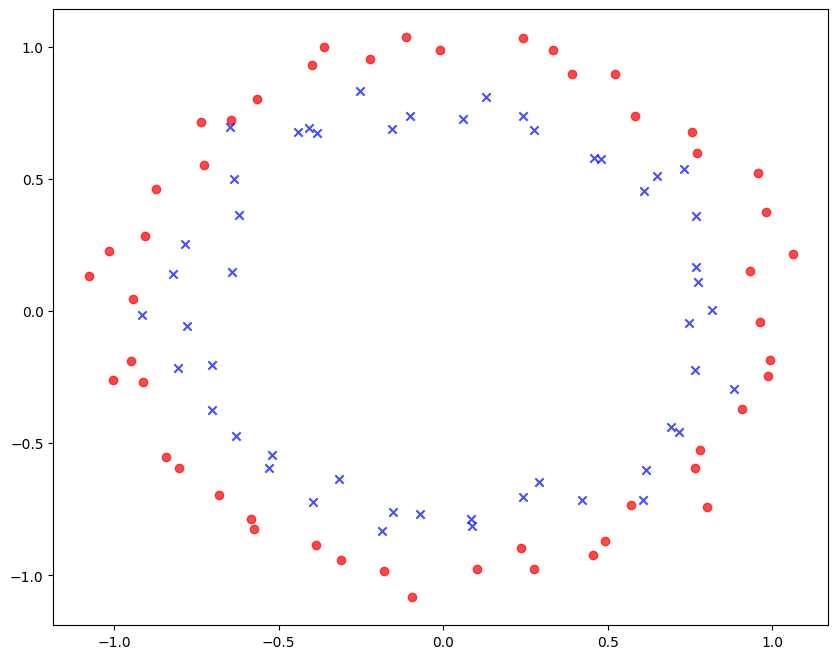

In [25]:
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.05, random_state=42)
print(X.shape, y.shape)
plt.figure(figsize=(10, 8))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], c='red', marker='o', label='Class 0', alpha=0.7)
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='blue', marker='x', label='Class 1', alpha=0.7)
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()
    X_test = torch.tensor(X, dtype=torch.float32)
    logits = model(X_test)
    accuracy = accuracy(logits, torch.tensor(y, dtype=torch.long))
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5100
